<h1 style="font-size:60px;" align=center>Keyword aggregation for search results</h1><img src="https://img.icons8.com/plasticine/2x/google-logo.png" width="200">

In [1]:
##################################################
## Scrape the results for searched keywords from google and plot a wordcloud with the results
##################################################
## Author: Aravind Venugopal
## Credits: [Aravind Venugopal]
## Version: 1.0.0
## Release: 1/24/2020
## Mmaintainer: Aravind Venugopal
## Email: venugopal.aravind94@gmail.com
## Status: Dev
## Website: Aravind-Venugopal.github.io
##################################################

In [18]:
from IPython.display import HTML,Image
# HTML('''<button id="close" class="closing" onClick="javascript:IPython.notebook.execute_cells_below()">Click to start Execution<img src="https://assets-cdn.github.com/images/modules/logos_page/GitHub-Mark.png" width=30px/></button>''')
HTML('''
<form action="javascript:IPython.notebook.execute_cells_below()"><input type="submit" value="Click here to start."></form>''')

In [19]:
import requests, re, math
import pandas as pd
from time import sleep
from IPython.display import display,clear_output, HTML
import ipywidgets as widgets
import warnings, urllib

try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
import matplotlib.pyplot as plt
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install bs4
from bs4 import BeautifulSoup
try:
    from tqdm import tqdm
except ImportError:
    !pip install tqdm
from tqdm import tqdm
try:
    from nltk import word_tokenize
except ImportError:
    !pip install nltk
from nltk.corpus import stopwords, words
try:
    from wordcloud import WordCloud, ImageColorGenerator
except ImportError:
    !pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
from IPython.display import HTML,Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
def search_google(search_term):
    base_url = 'https://www.google.com/search?q='
    search_term_urlencoded = urllib.parse.quote_plus(search_term)
    
    # set headers   
    headers = {
    'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36"
    }
    
    urls = [base_url+search_term_urlencoded]+[base_url+search_term_urlencoded+'&start={}'.format(i*10) for i in range(1,int(page_slider.value/10))]
    
    # loop through Google searches

    results = []

    for ix, url in enumerate(tqdm(urls)):
        r = requests.get(url, headers = headers)
        google_soup = BeautifulSoup(r.content,'html.parser')
    #     print(r.status_code)
        try:
            res = [a.find('a', href = True)['href'] for a in google_soup.find_all('div', class_ = 'r')]
        except:
            pass
        results = results+res

    pd.DataFrame(results, columns = ['Link']).to_csv('search_results.csv')
    return results

In [22]:
def plot_wordcloud(df):
    display(HTML('<img src="https://media.giphy.com/media/13KjWgCrVY08uY/giphy.gif" width="200" height="200" align="centre"/>'))
    
    search_term = query.value
    
    text = ' '.join(df['Content'].values)
#     text = text.replace(search_term, '')
    
    stopword_list = stopwords.words('english')
#     stopword_list.append(search_term)

    tokens = word_tokenize(text)    
    tokens = [token.strip() for token in tokens]    
    text = ' '.join([token for token in tokens if token not in stopword_list and bool(re.search(r'\d', token))==False])

    wordcloud = WordCloud(width = 1600, height = 800, 
                    background_color ='white', 
                    stopwords = stopword_list, 
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (20, 14), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    # plt.tight_layout(pad = 0) 
    clear_output()
    display(query)
    plt.show() 
    plt.savefig(search_term+'.jpg',bbox_inches='tight')
    

In [23]:
def fetch_pages(search_term):
    
    clear_output()
    display(query)
    
    # Fetch google results
    results = search_google(search_term.value)

    # Removing duplicate results
    results = list(set(results))
    
    headers = {
    'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36"
    }
    
    
    # loop through the results
    page_text = []
    clear_output()
    display(query)
    for ix, url in enumerate(tqdm(results)):
        try:
            s = requests.get(url, headers = headers, timeout=10)
        except:
            continue
        soup = BeautifulSoup(s.content,'html.parser')
        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()    # rip it out

        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)

        page_text.append(text)

    #     if ix%20==0:
    #         pd.DataFrame(page_text, columns = ['Content']).to_csv('search_results_content_{}.csv'.format(ix))
    #         page_text = []
    df = pd.DataFrame(page_text, columns = ['Content'])
    clear_output()
    display(query)
    plot_wordcloud(df)

## Select number of results to fetch

In [24]:
page_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=150,
    step=10,
    description='Results:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(page_slider)

IntSlider(value=100, continuous_update=False, description='Results:', max=150, min=10, step=10)

## Input search term

Text(value='japan', description='Enter query:', layout=Layout(height='100%', width='100%'), placeholder="I'm F…

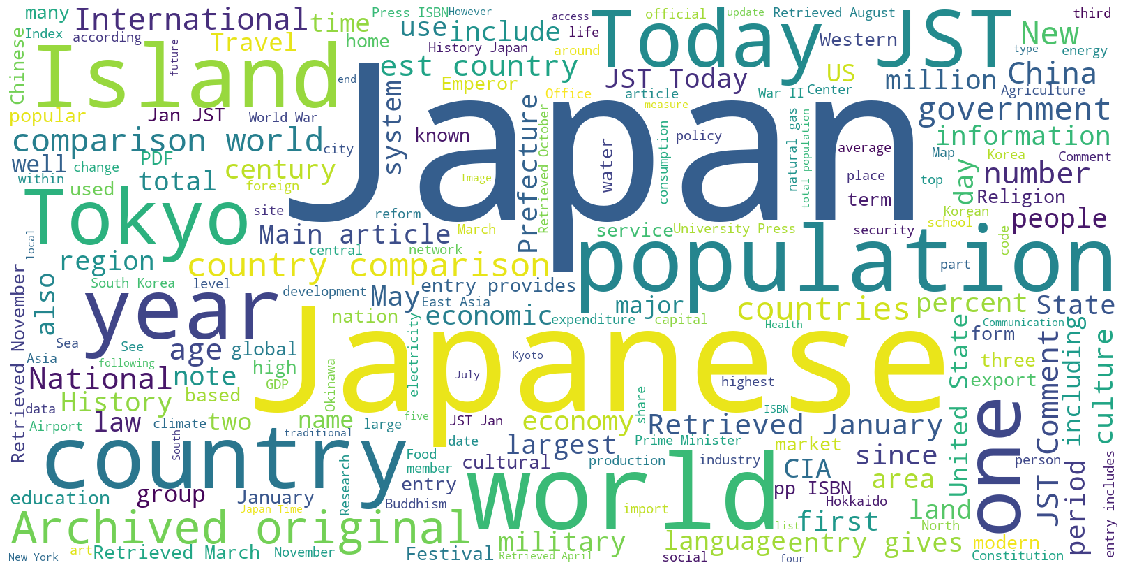

<Figure size 432x288 with 0 Axes>

In [25]:
query = widgets.Text(
#     value='',
    placeholder="I'm Feeling Lucky",
    description='Enter query:',
#     height = 8000,
#     width = 2800,
    disabled=False,
    layout={'height': '100%','width': '100%'}
)
display(query)

query.on_submit(fetch_pages)